In [64]:
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets, svm, linear_model
matplotlib.style.use('bmh')
matplotlib.rcParams['figure.figsize']=(10,7)
import requests
from io import BytesIO

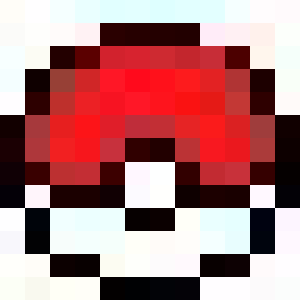

In [65]:
response = requests.get("https://imgur.com/hnjmdcv.jpg")
pixels = np.array(Image.open(BytesIO(response.content)))
Image.fromarray(pixels).resize((300,300), Image.NEAREST)

In [66]:
palette =  list(set(tuple(x) for x in pixels.reshape(-1, 3)))

In [67]:
reverse_palette = {c:i for i, c in enumerate(palette)}

In [68]:
h, w = pixels.shape[:2]
X = np.mgrid[0:h, 0:w].reshape(2, -1).T
y = np.array([reverse_palette[tuple(x)] for x in pixels.reshape(-1,3)])

In [69]:
X = X.astype('float64')

In [70]:
X=np.concatenate([X, X+[.1,.1], X+[.1,-.1], X+[-.1,.1], X+[-.1,-.1]])
y = np.concatenate([y,y,y,y,y])

In [71]:
from matplotlib.colors import LinearSegmentedColormap
cm= LinearSegmentedColormap.from_list(
        "cmm", np.array(palette)/255 )
matplotlib.rcParams['figure.figsize']=(10,10*h/w)

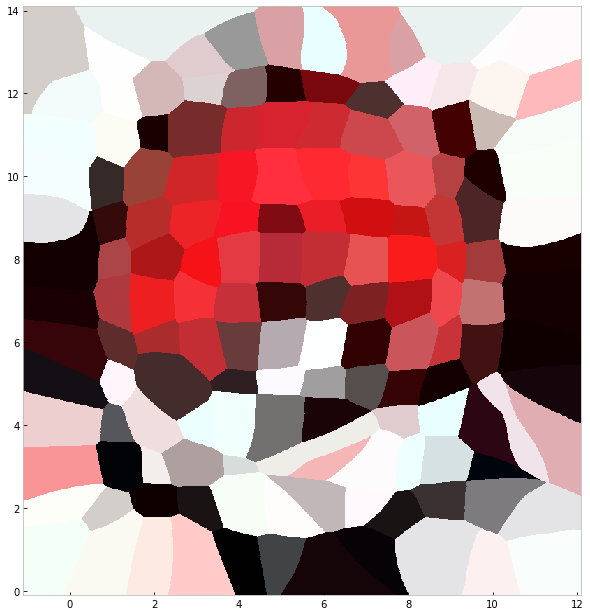

In [72]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

#嘗試過不同隱藏層數，最終結果為3000次&隱藏層(512,256)層與原圖最為相符
clf=MLPClassifier(hidden_layer_sizes=(512,256), learning_rate_init=1e-3, max_iter=3000, solver="lbfgs")

X_mean = X.mean(axis=0,keepdims=True)
X_std = X.std(keepdims=True)
W = (X - X_mean)/X_std
X2 = np.concatenate( [W, W**2, (W[:, 0]*W[:, 1])[:, None] ], axis= 1)
X2_mean = X2.mean(axis=0,keepdims=True)
X2_std = X2.std(keepdims=True)
clf.fit((X2-X2_mean)/X2_std, y)

x_min, y_min = X.min(axis=0)-1
x_max, y_max = X.max(axis=0)+1
grid  = np.mgrid[x_min:x_max:800j, y_min:y_max:800j]
W = (grid.reshape(2, -1).T - X_mean)/X_std
W2 = np.concatenate( [W, W**2,  (W[:, 0]*W[:, 1])[:, None] ], axis= 1)
# grid.shape = (2, 200, 200)


Z = clf.predict( (W2-X2_mean)/X2_std )
Z  = Z.reshape(grid.shape[1:])
plt.pcolormesh(grid[1], h-grid[0], Z, cmap=cm, alpha=1);